In [1]:
import time, pickle, re, sys, os, jsonlines, random, collections, math, omegaconf
import ujson as json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from copy import deepcopy
from multiprocessing.pool import ThreadPool
from functools import partial
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import scipy
from collections import Counter

# import GPUtil

# gpu_id = '2' #'1'
# os.environ['CUDA_VISIBLE_DEVICES']=gpu_id       # do before importing torch

from einops import rearrange
import torch
from torch import nn
import torch.nn.functional as F

In [11]:
# !kill -SIGKILL 14067

# errors at low ht propagate to higher hts - compounding effect

In [4]:
# !find ../../../../outputs/2022-10-17/ -maxdepth 4 -name "*mpvpklfq*" -print  # dlr
!find ../../../../outputs/2022-11-29/ -maxdepth 4 -name "*tj6go7ag*" -print  # attn

../../../../outputs/2022-11-29/18-57-28/wandb/run-20221129_185744-tj6go7ag
../../../../outputs/2022-11-29/18-57-28/wandb/run-20221129_185744-tj6go7ag/run-tj6go7ag.wandb


In [5]:
# !ls '../../../../outputs/2022-10-17/09-39-02/checkpoints/val/accuracy_ignore_m100.ckpt'
!ls '../../../../outputs/2022-11-29/18-57-28/checkpoints/val/accuracy_ignore_m100.ckpt'

../../../../outputs/2022-11-29/18-57-28/checkpoints/val/accuracy_ignore_m100.ckpt


torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Size([32])
torch.Size([32, 8192]) torch.Size([32, 8192]) torch.Siz

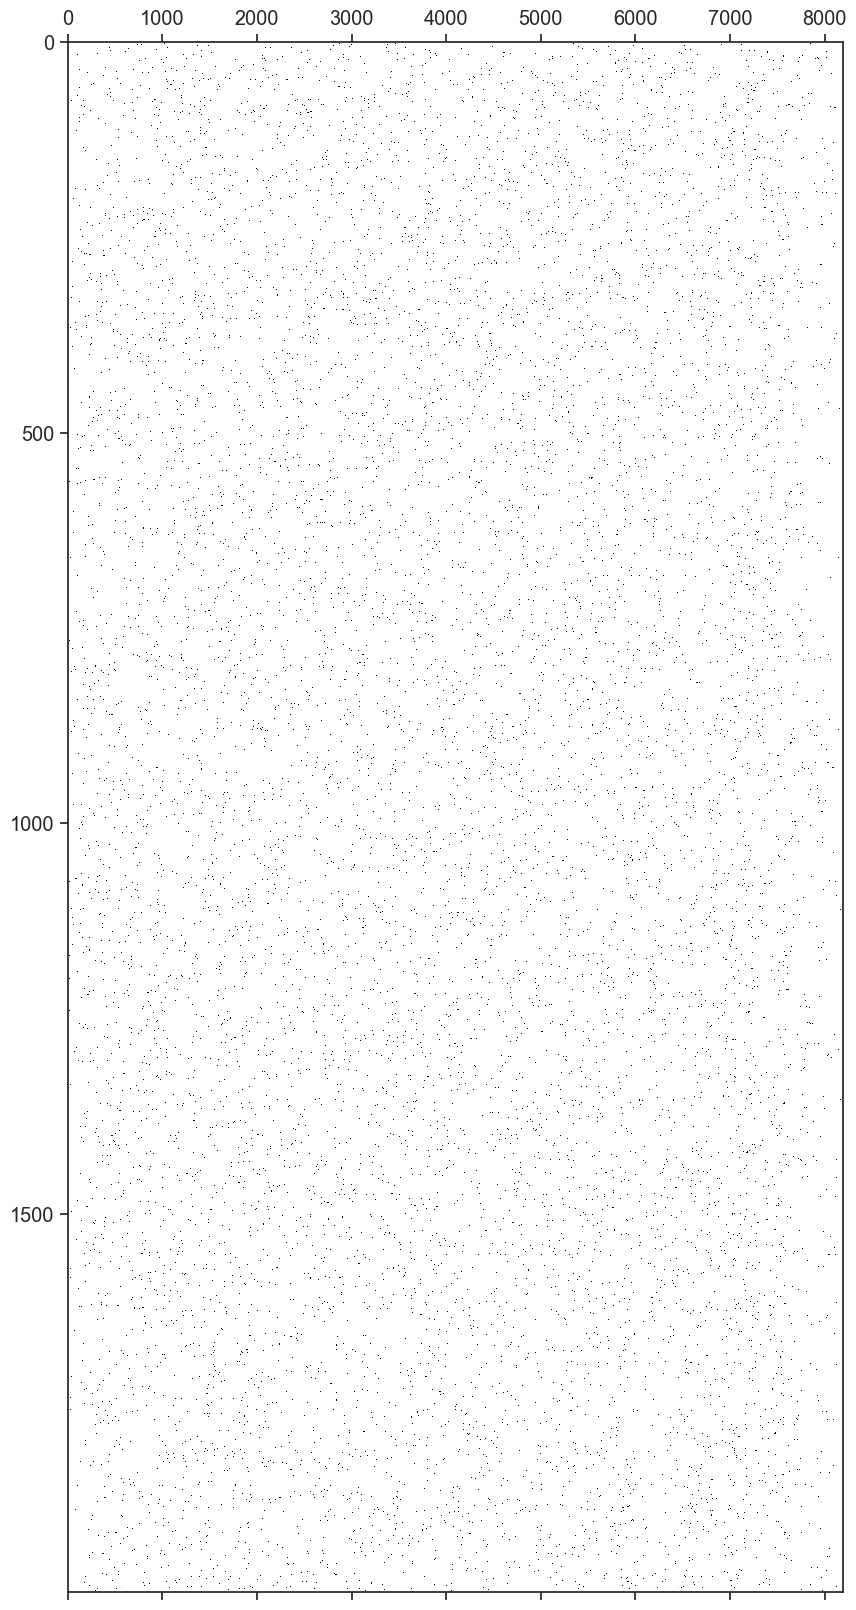

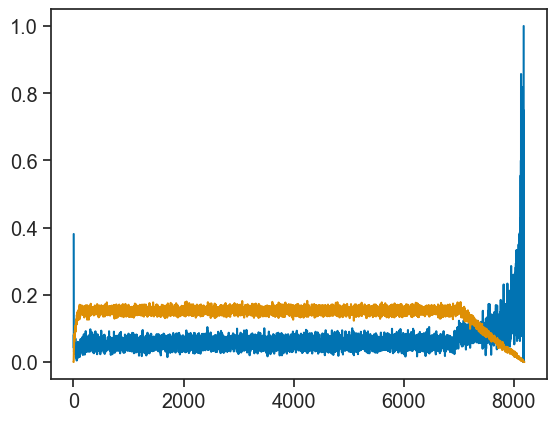

In [63]:
# direc = '../../../../outputs/2022-11-04/09-23-16/val_outputs'     # DLR
direc = '../../../../outputs/2022-12-06/13-43-42/val_outputs'   # local attention

all_pred, all_true, all_ids = [], [], []

for i_b in range(0,62):
    outs = torch.load(direc+ f'/cuda:0_{i_b}_0.pt', map_location='cpu')
    # for x in outs[:]:
    #     print(x.shape)
    y_pred, y_true, ids = outs[0].argmax(-1), outs[1], outs[2][0]
    print(y_pred.shape, y_true.shape, ids.shape)
    all_pred.append(y_pred); all_true.append(y_true); all_ids.append(ids) 

y_pred, y_true, ids = map(torch.cat, (all_pred, all_true, all_ids))

# y_pred, y_true = y_pred[...,:1500], y_true[...,:1500]
    
print(y_pred.shape, y_true.shape, ids.shape)
errors = ((y_pred != y_true) & (-100 != y_true)).long()
correct = ((y_pred == y_true) & (-100 != y_true)).long()
print(errors.sum() / (-100 != y_true).sum())

plt.figure(figsize=(10,20))
plt.matshow(errors, cmap='binary', fignum=1, aspect='auto')
# plt.matshow(correct*2, cmap='binary', fignum=1, aspect='auto', vmin=0, vmax=2)
plt.show()
plt.plot((errors.float().sum(0)/(-100 != y_true).float().sum(0))[:])
plt.plot((-100 != y_true).float().mean(0)[:])

In [64]:
# index_dataset = dataset.iloc[ids.long().numpy()-96000]
sub_lengths, sub_heights, sub_vals, sub_ops = torch.zeros_like(y_true)-1, torch.zeros_like(y_true)-1, torch.zeros_like(y_true)-1, []
for i in range(len(ids)):
    id = ids[i].item()
    row = df[df['Id'] == id]
    to_tensor = lambda x: torch.LongTensor(x.tolist()).view(-1)
    lens = to_tensor(row.SubTreeLengths)
    sub_lengths[i,:len(lens)] = lens
    
    hts = to_tensor(row.SubTreeHeights)
    sub_heights[i,:len(hts)] = hts
    
    vals = to_tensor(row.SubTreeEvals)
    sub_vals[i,:len(vals)] = vals
    
    sub_ops.append(row.SubTreeOps.tolist()[0])
    sub_ops[-1] = sub_ops[-1] + ['<pad>']*(sub_vals.size(-1) - len(sub_ops[-1]))
sub_ops = np.array(sub_ops)

1 1062569.0 197.0 1062372.0 0.0001853997246296476 0.9998146002753704
2 474536.0 3359.0 471177.0 0.007078493517878517 0.9929215064821215
3 265914.0 18659.0 247255.0 0.07016930285731478 0.9298306971426852
4 164809.0 25156.0 139653.0 0.15263729529333955 0.8473627047066604
5 107793.0 20907.0 86886.0 0.1939550805710946 0.8060449194289054
6 72670.0 15762.0 56908.0 0.21689830741709096 0.7831016925829091
7 49846.0 12194.0 37652.0 0.24463347109096015 0.7553665289090399
8 34257.0 9740.0 24517.0 0.2843214525498438 0.7156785474501561
9 23734.0 7782.0 15952.0 0.32788404820089323 0.6721159517991068
10 16220.0 6414.0 9806.0 0.39543773119605424 0.6045622688039457
11 10732.0 5271.0 5461.0 0.49114796869176297 0.5088520313082371
12 6847.0 4035.0 2812.0 0.5893091865050387 0.4106908134949613
13 4020.0 2790.0 1230.0 0.6940298507462687 0.30597014925373134


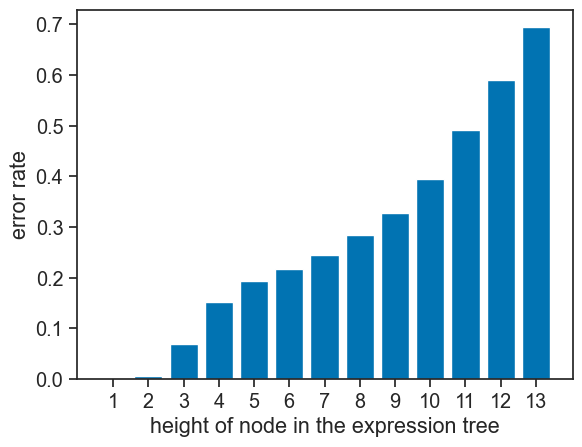

In [65]:
ht_err_ratio = {}
ht_df = []
for ht in range(1, sub_heights.max().item()):
    total_ht = (sub_heights == ht).float().sum().item()
    if not total_ht: continue
    err_ht = ((sub_heights == ht) & errors).float().sum().item()
    correct_ht = ((sub_heights == ht) & correct).float().sum().item()  
    print(ht, total_ht, err_ht, correct_ht, err_ht / total_ht, correct_ht/total_ht)
    ht_err_ratio[ht] = err_ht / total_ht
    ht_df.append({'idx': ht, 'total_count': total_ht, 'error_count': err_ht})
plt.bar(ht_err_ratio.keys(), ht_err_ratio.values());
plt.xlabel('height of node in the expression tree')
plt.ylabel('error rate')
plt.xticks(list(ht_err_ratio.keys()));

<AxesSubplot:xlabel='idx'>

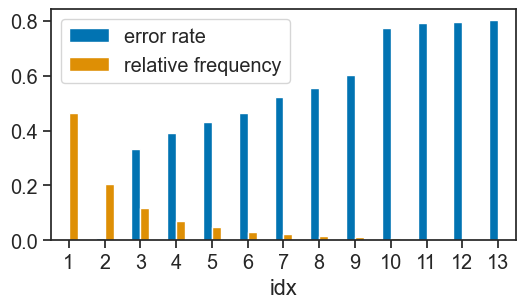

In [46]:
import seaborn as sns 
sns.set_theme(palette='colorblind', font_scale=1.3, style='ticks')

ht_df = pd.DataFrame(ht_df)
ht_df['error rate'] = ht_df['error_count'] / ht_df['total_count']
ht_df['relative frequency'] = ht_df['total_count'] / ht_df['total_count'].sum()
ht_df.index = ht_df.idx

ht_df[['error rate', 'relative frequency', 'idx']].plot.bar(x='idx', rot=0, figsize=(6,3))
# plt.xlabel('height of node in the expression tree')
# # plt.savefig('../../../../misc/plots/listops_subtrees_8192_dlr_height_err.pdf', bbox_inches='tight')
# plt.savefig('../../../../misc/plots/listops_subtrees_8192_attn_height_err.pdf', bbox_inches='tight')

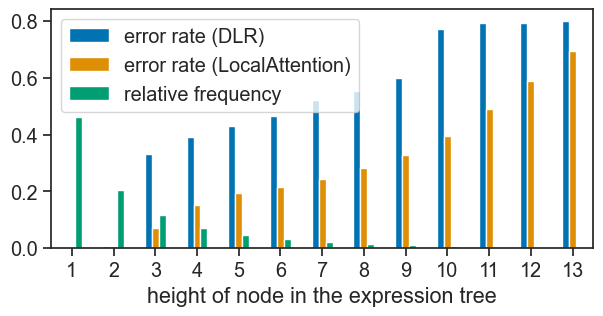

In [59]:
# ht_df_dlr = ht_df.copy().rename(columns={'error rate': 'error rate (DLR)'})
# ht_df_attn = ht_df.rename(columns={'error rate': 'error rate (LocalAttention)'})

# ht_df_cat = ht_df_attn.copy()
# ht_df_cat['error rate (DLR)'] = ht_df_dlr['error rate (DLR)']
# ht_df_cat[['error rate (DLR)', 'error rate (LocalAttention)', 
#            'relative frequency', 'idx']].plot.bar(x='idx', rot=0, figsize=(7,3.1))
# plt.xlabel('height of node in the expression tree')
# plt.savefig('../../../../misc/plots/listops_subtrees_8192_dlr_attn_height_err.pdf', bbox_inches='tight')

Text(0, 0.5, 'error')

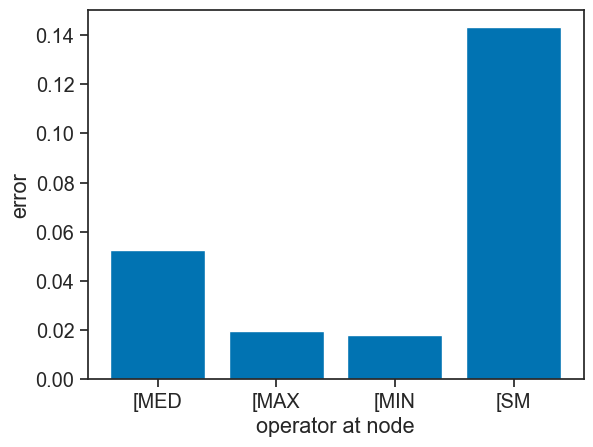

In [66]:
ht_err_ratio = {}
ht_df = []
l = sub_ops
for ht in set(l.reshape(-1)).difference({'<pad>', 'NONE'}):
    total_ht = (l == ht).sum().item()
    if not total_ht: continue
    err_ht = ((l == ht) & errors.numpy()).sum()
    correct_ht = ((l == ht) & correct.numpy()).sum()
    # print(ht, total_ht, err_ht, correct_ht, err_ht / total_ht, correct_ht/total_ht)
    ht_err_ratio[ht] = err_ht / total_ht
    ht_df.append({'idx': ht, 'total_count': total_ht, 'error_count': err_ht})
plt.bar(ht_err_ratio.keys(), ht_err_ratio.values())
plt.xlabel('operator at node')
plt.ylabel('error')
# plt.xticks(list(ht_err_ratio.keys()));

In [67]:
ht_df = pd.DataFrame(ht_df)
ht_df['error rate'] = ht_df['error_count'] / ht_df['total_count']
ht_df['relative frequency'] = ht_df['total_count'] / ht_df['total_count'].sum()
ht_df.index = ht_df.idx

# ht_df[['error rate', 'relative frequency', 'idx']].plot.bar(x='idx', rot=0, figsize=(6,3))
# plt.xlabel('operator at node in the expression tree')
# plt.savefig('../../../../misc/plots/listops_subtrees_8192_dlr_op_err.pdf', bbox_inches='tight')
# plt.savefig('../../../../misc/plots/listops_subtrees_8192_attn_op_err.pdf', bbox_inches='tight')

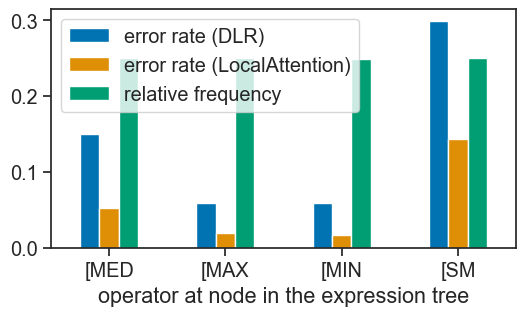

In [81]:
# ht_df_dlr = ht_df.copy().rename(columns={'error rate': 'error rate (DLR)'})
# ht_df_attn = ht_df.rename(columns={'error rate': 'error rate (LocalAttention)'})

ht_df_cat = ht_df_attn.copy()
ht_df_cat['error rate (DLR)'] = ht_df_dlr['error rate (DLR)']
ht_df_cat[['error rate (DLR)', 'error rate (LocalAttention)', 
           'relative frequency', 'idx']].plot.bar(x='idx', rot=0, figsize=(6,3.1))
plt.xlabel('operator at node in the expression tree')
# plt.savefig('../../../../misc/plots/listops_subtrees_8192_dlr_attn_op_err.pdf', bbox_inches='tight')

Text(0, 0.5, 'error')

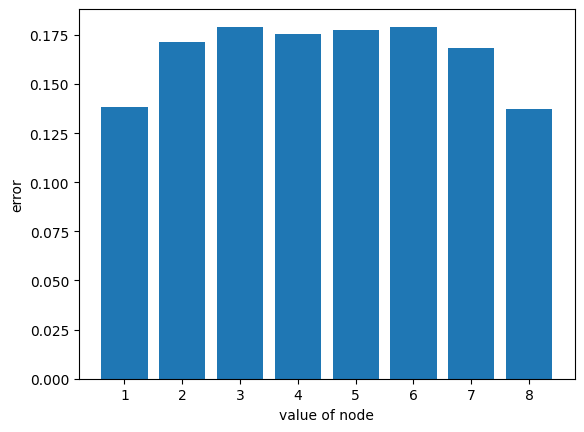

In [15]:
ht_err_ratio = {}
l = sub_vals
for ht in range(1, l.max().item()):
    total_ht = (l == ht).float().sum().item()
    if not total_ht: continue
    err_ht = ((l == ht) & errors).float().sum().item()
    correct_ht = ((l == ht) & correct).float().sum().item()  
    # print(ht, total_ht, err_ht, correct_ht, err_ht / total_ht, correct_ht/total_ht)
    ht_err_ratio[ht] = err_ht / total_ht
plt.bar(ht_err_ratio.keys(), ht_err_ratio.values())
plt.xlabel('value of node')
plt.ylabel('error')
# plt.xticks(list(ht_err_ratio.keys()));

In [ ]:
ht_err_ratio = {}
l = sub_lengths
for ht in range(1, l.max().item()):
    total_ht = (l == ht).float().sum().item()
    if not total_ht: continue
    err_ht = ((l == ht) & errors).float().sum().item()
    correct_ht = ((l == ht) & corsnst).float().sum().item()  
    # print(ht, total_ht, err_ht, correct_ht, err_ht / total_ht, correct_ht/total_ht)
    ht_err_ratio[ht] = err_ht / total_ht
plt.bar(ht_err_ratio.keys(), ht_err_ratio.values())
plt.xlabel('length of (expression at) node')
plt.ylabel('error')
# plt.xticks(list(ht_err_ratio.keys()));

In [3]:
import pandas as pd

df = pd.read_csv("../../../../data/listops_subtrees/subtrees_val.tsv", sep='\t')
print(df.columns)
df['SubTreeInds'] = df.apply(lambda x: list(map(int, x.SubTreeInds.split())), axis=1)
df['Len'] = df.apply(lambda x: len(x.Source.split()), axis=1)

def f(row, col, typ='int'):
    if typ == 'int':
        l = [-1]*row.Len
        for ind, val in zip(row.SubTreeInds, row[col].split()):
            l[ind] = int(val)
    else:
        l = ['NONE']*row.Len
        for ind, val in zip(row.SubTreeInds, row[col].split()):
            l[ind] = val
    return l
    
for col in ['SubTreeEvals', 'SubTreeLengths', 'SubTreeHeights']:
    df[col] = df.apply(lambda row: f(row, col), axis=1)
for col in ['SubTreeOps']:
    df[col] = df.apply(lambda row: f(row, col, 'str'), axis=1)
    
df

Index(['Source', 'Target', 'SubTreeEvals', 'SubTreeLengths', 'SubTreeHeights',
       'SubTreeOps', 'SubTreeInds', 'Id'],
      dtype='object')


,Source,Target,SubTreeEvals,SubTreeLengths,SubTreeHeights,SubTreeOps,SubTreeInds,Id,Len
0,[MAX 2 6 [SM [SM 3 1 6 5 5 ] 8 3 [MED 0 1 3 [S...,6,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[10, 39, 57, 63, 66, 68, 86, 87, 97, 103, 121,...",96000,7282
1,[MAX 2 [MAX [MED 5 8 9 2 [MAX 3 3 4 3 ] 0 [MAX...,8,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[13, 30, 51, 53, 54, 57, 59, 61, 78, 80, 87, 8...",96001,7849
2,[MAX 1 0 0 [MAX 9 2 9 4 4 3 [MIN 4 2 4 5 4 ] 7...,9,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[17, 22, 23, 65, 74, 80, 91, 92, 93, 95, 99, 1...",96002,7404
3,[MED 3 [MAX [MIN 9 8 6 [MIN 1 [MED 0 [MIN [MED...,6,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[36, 48, 50, 56, 65, 69, 74, 75, 97, 101, 110,...",96003,7125
4,[MED [MIN 2 9 2 [MIN 9 0 ] 1 3 ] 7 6 [MIN [SM ...,6,"[-1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0,...","[-1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, 11...","[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 2,...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[8, 11, 63, 70, 78, 87, 88, 98, 105, 110, 119,...",96004,7423
...,...,...,...,...,...,...,...,...,...
1995,[SM 2 2 [SM 3 6 2 0 0 ] [MED 8 [MED 5 [MIN 8 3...,8,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[9, 20, 32, 36, 49, 55, 65, 79, 88, 92, 93, 10...",97995,7573
1996,[SM 8 [MAX 8 0 8 4 [MED [SM 2 7 9 9 1 [MED 3 8...,1,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[20, 24, 29, 34, 41, 54, 61, 81, 88, 92, 99, 1...",97996,7164
1997,[SM [MIN 8 [MIN [MIN 8 0 [MAX 4 [MED [MAX [MIN...,3,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[21, 30, 31, 37, 61, 62, 76, 80, 91, 101, 106,...",97997,7520
1998,[MAX 2 8 [MED 7 7 [MAX 9 9 [MIN 2 [MED 1 6 9 [...,8,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...","[43, 45, 56, 59, 65, 66, 68, 70, 76, 83, 103, ...",97998,7454


In [ ]:
df.iloc[0].Source, df.iloc[0].SubTreeEvals

In [5]:
# Counter(sum(df.SubTreeHeights, []))
df[['Len']].describe()

,Len
count,2000.000000
mean,7548.151000
std,333.481368
min,7001.000000
25%,7260.000000
50%,7529.000000
75%,7823.250000
max,8179.000000


In [16]:
df_orig = pd.read_csv("../../../../data/listops/basic_val.tsv", sep='\t')
df_orig['Len'] = df_orig.apply(lambda x: len(listops_tokenizer(x.Source)), axis=1)

df_orig[['Len']].describe()

,Len
count,2000.000000
mean,1034.675500
std,394.979735
min,502.000000
25%,693.750000
50%,960.000000
75%,1303.250000
max,1999.000000


In [10]:
df.iloc[0]

Source            [MAX 2 6 [SM [SM 3 1 6 5 5 ] 8 3 [MED 0 1 3 [S...
Target                                                            6
SubTreeEvals      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1...
SubTreeLengths    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1...
SubTreeHeights    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...
SubTreeOps        [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...
SubTreeInds       [10, 39, 57, 63, 66, 68, 86, 87, 97, 103, 121,...
Id                                                            96000
Len                                                            7282
Name: 0, dtype: object

In [11]:
def listops_tokenizer(s):
    return s.translate({ord("]"): ord("X"), ord("("): None, ord(")"): None}).split()

# df['Source_len'] = df['Source'].apply(lambda x: len(listops_tokenizer(x)))
# df['SubTreeEvals_len'] = df['SubTreeEvals'].apply(lambda x: len(listops_tokenizer(x)))
# df

array([[<AxesSubplot:title={'center':'Len'}>]], dtype=object)

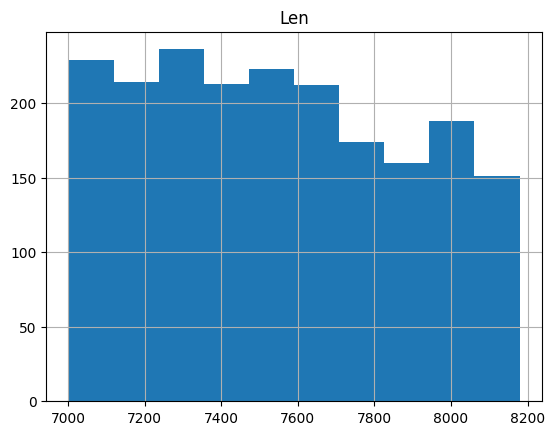

In [9]:
df[['Len']].hist()

In [10]:
!du -sh '../../../../data/listops_subtrees/'

1.5G	../../../../data/listops_subtrees/


In [25]:
def bracket_matching(L, num_labels, pr_open=.7):
    x, y, stack = [], [], []
    for i in range(L):
        if not stack:
            choice = 1
        elif len(stack) >= L - i:
            choice = 0 
        else:
            choice = int(random.random() < pr_open)  # 1: '('  , 0: ')'    
        if choice:
            stack.append(random.randint(1,num_labels))
            y.append(stack[-1])
        else:
            y.append(stack.pop())
        x.append(choice)
    x, y = map(np.array, (x,y))
    return x, x*y, y

bracket_matching(32,10)

(array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 3,  3,  3,  6,  0,  5,  7,  0,  8, 10,  7,  5,  3,  4, 10,  0,  7,
         6, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 3,  3,  3,  6,  6,  5,  7,  7,  8, 10,  7,  5,  3,  4, 10, 10,  7,
         6, 10, 10,  6,  7,  4,  3,  5,  7, 10,  8,  5,  3,  3,  3]))